In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os
import math
import numpy as np

import sys
sys.path.append('../bgc-analysis')
from  calc_sensor import pH_sbe, o2_sbe
from db_api import get_cal, get_metadata_all

In [38]:
floatnums = 1358, 1483

In [39]:
root = r"G://Shared drives//WHOI Argo//BGC//Float Tracking//flow_through_data//" + str(floatnums[0]) + "//"
files = [x for x in os.listdir(root) if x.endswith(".pkl")]
files

['F1358_20230511.pkl', 'F1483_20230511.pkl']

In [40]:
data = pd.DataFrame(columns=['DATE', 'SN', 'PRES', 'TEMP', 'PSAL', 'O2_PHASE_DELAY',
       'O2_TEMPERATURE_VOLTAGE', 'MCOMS1', 'MCOMS2', 'MCOMS3', 'PH_VRS1', 'PH_VRS', 'PH_VK', 'PHIB', 'PHIK', 'PHVIN', 'PHVOUT', 'NITRATE'])

for file in files:
    data = data.append(pd.read_pickle(root+'/'+file))
data = data.sort_values('DATE')
data['DATE'] = data['DATE'].dt.round('1s')
data = data.reset_index()
print(data)

     index                DATE    SN  PRES     TEMP    PSAL  O2_PHASE_DELAY  \
0        0 2023-05-11 12:24:29  1358  -0.3  19.4496  31.897          17.464   
1        1 2023-05-11 12:27:10  1358  -0.3  19.5136  31.897          17.456   
2        2 2023-05-11 12:29:51  1358  -0.3  19.5775  31.897          17.439   
3        3 2023-05-11 12:32:33  1358  -0.3  19.6392  31.897          17.425   
4        4 2023-05-11 12:35:14  1358  -0.3  19.7012  31.897          17.409   
..     ...                 ...   ...   ...      ...     ...             ...   
100     59 2023-05-11 15:02:51  1358  -0.3  22.1250  31.927          17.029   
101     41 2023-05-11 15:05:23  1483  -0.1  22.1416  31.951          16.880   
102     60 2023-05-11 15:05:33  1358  -0.3  22.1516  31.927          17.025   
103     42 2023-05-11 15:08:04  1483  -0.1  22.1701  31.951          16.878   
104     61 2023-05-11 15:08:14  1358  -0.3  22.1767  31.928          17.028   

     O2_TEMPERATURE_VOLTAGE  MCOMS1    MCOMS2  MCOM

C:\Users\aidan.thayer\AppData\Local\Temp\ipykernel_22284\128781946.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_pickle(root+'/'+file))
C:\Users\aidan.thayer\AppData\Local\Temp\ipykernel_22284\128781946.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_pickle(root+'/'+file))


In [41]:
wmo = get_metadata_all('PLATFORM_NUMBER')
snall = get_metadata_all('FLOAT_SERIAL_NO')
wmosn = pd.DataFrame(wmo)
wmos = []
wmosn['SN'] = snall
smp = []

for i, sn in enumerate(wmosn['SN']):
    sn = int(sn)
    if sn == floatnums[1]:
        wmos.append(i)
    if sn == floatnums[0]:
            wmos.append(i)
for w in wmos:
    smp.append(wmosn['PLATFORM_NUMBER'][w])
print(smp)


['3', '58']


In [42]:
for sn in data.SN.unique():
    print(sn)
    cal = get_cal(smp)

    
    sub = data.loc[data.SN == sn,:]
    
    #PH
    PH_FREE, data.loc[data.SN ==sn, 'PH_TOTAL'] = pH_sbe(cal['TRANSISTOR_PH']['PREDEPLOYMENT_CALIB_COEFFICIENT'],sub.PH_VRS1, sub.PRES, sub.TEMP, sub.PSAL)

    #Oxygen
    data.loc[data.SN==sn, 'DOXY'] = (o2_sbe(cal['OPTODE_DOXY']['PREDEPLOYMENT_CALIB_COEFFICIENT'], sub.O2_PHASE_DELAY, sub.O2_TEMPERATURE_VOLTAGE, sub.PRES, sub.TEMP, sub.PSAL)[0])

1358
1483


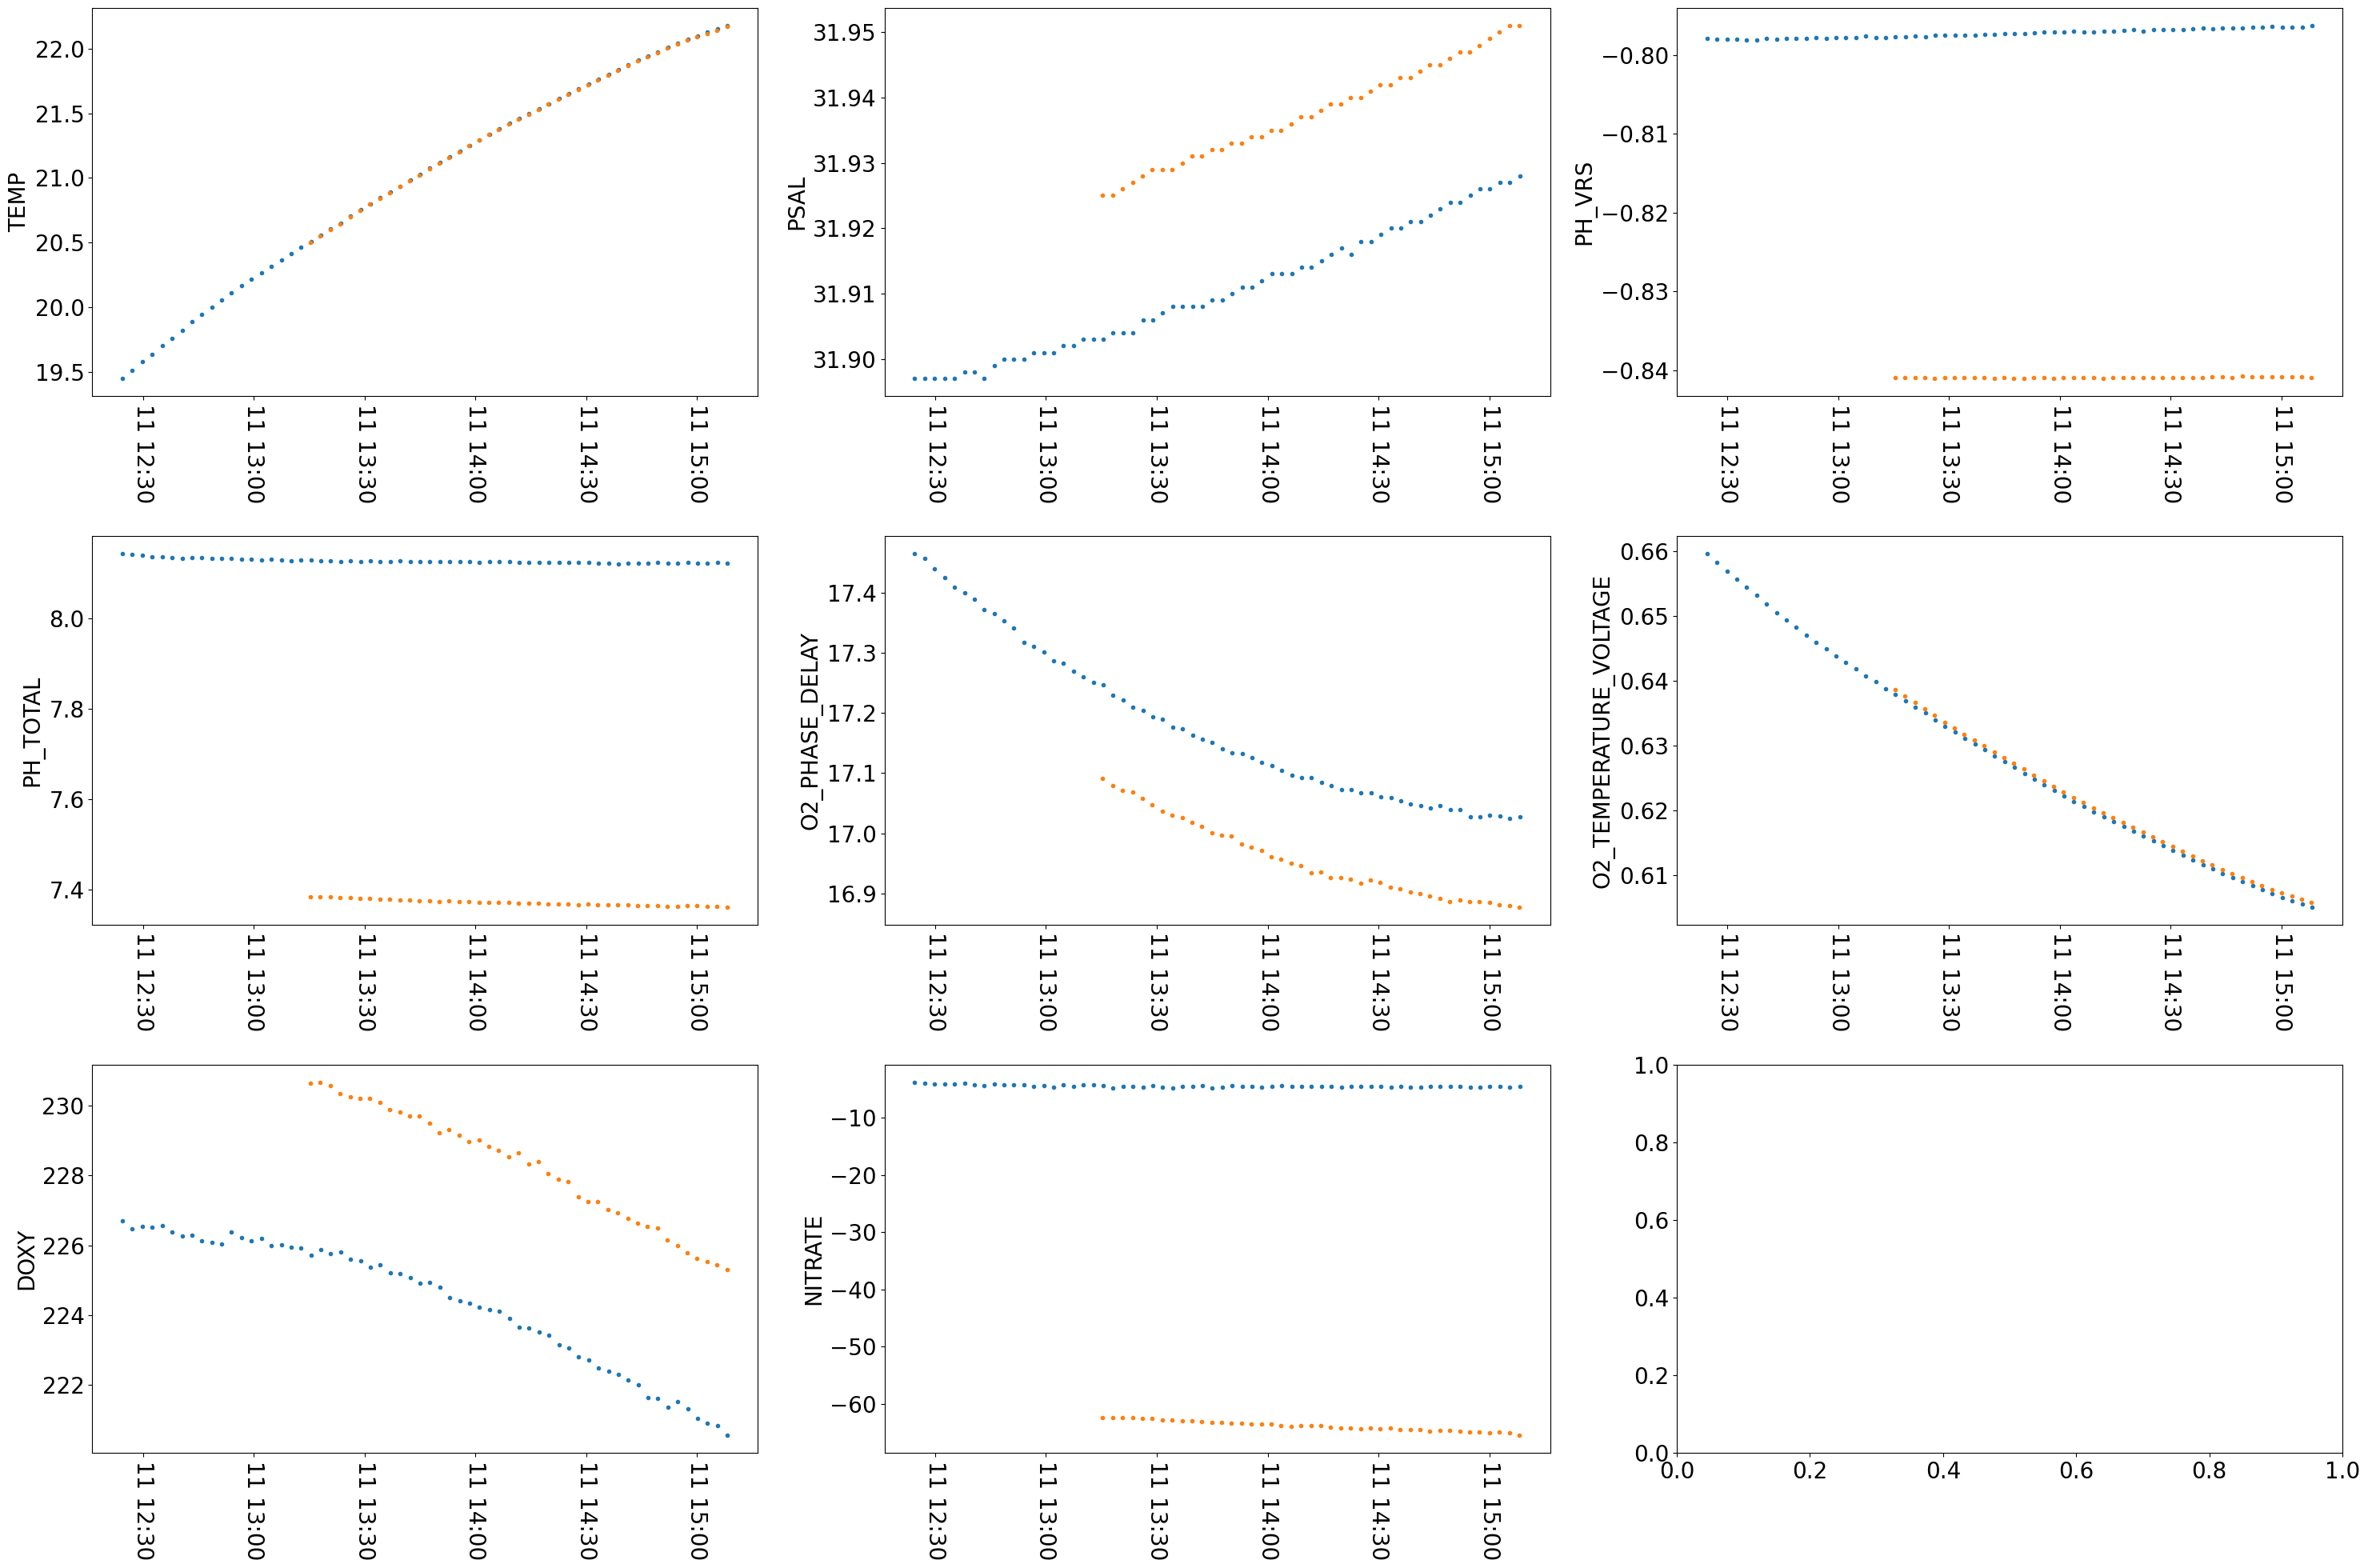

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(30, 20)) #Create figure



#Add trace for each float and variable
sns = data.SN.unique()

for i, var in enumerate(['TEMP', 'PSAL', 'PH_VRS', 'PH_TOTAL','O2_PHASE_DELAY','O2_TEMPERATURE_VOLTAGE','DOXY', 'NITRATE']):
    for sn in sns:
        col = i%3
        row = math.floor(i/3)

        sub = data.loc[data.SN == sn]
        axs[row][col].plot(sub.DATE, sub[var], marker=".", linestyle='None')

        #Formatting
        axs[row][col].set_ylabel(var)
        dateFormat = DateFormatter("%d %H:%M")
        axs[row][col].xaxis.set_major_formatter(dateFormat)
        axs[row][col].tick_params(axis='x', rotation=-90)
        fig.tight_layout()
        
plt.rcParams.update({'font.size': 20})

#fig.legend(wmosn['SN'][wmos])